# Projet 5 - Segmentez des clients d'un site e-commerce (Partie 1)

> 🎓 OpenClassrooms • Parcours [AI Engineer](https://openclassrooms.com/fr/paths/795-ai-engineer) | 👋 *Etudiant* : [David Scanu](https://www.linkedin.com/in/davidscanu14/)

## 📊 Partie 1 : Création de l'échantillon d'apprentissage

Ce notebook contient la première partie du projet dédiée à la création de l'échantillon d'apprentissage pour la segmentation client.

Une seconde partie est dédiée à l'analyse exploratoire des données (EDA). L'objectif principal de cette section est de mieux comprendre la nature et la qualité des données afin d'identifier les transformations nécessaires pour la préparation, le feature engineering et le preprocessing des variables.

- Importer et préparer les données.
- Identifier les variables clés pour la segmentation.
- Effectuer une analyse descriptive (statistiques, visualisations, corrélations).

## ⚡ Mission

Nous sommes **consultant pour Olist** et nous avons été chargé de **réaliser cette segmentation**, en mettant en place des modèles d'**apprentissage non supervisé** et en fournissant un **plan de maintenance** du modèle.

**Segmentation client**

- Explorer et analyser les données fournies.
- Mettre en place une segmentation des clients en utilisant des algorithmes d’apprentissage non supervisé (ex. clustering).
- Fournir une analyse approfondie des segments obtenus pour une exploitation optimale par l'équipe Marketing.
- Proposer un plan de maintenance basé sur une simulation de fréquence de mise à jour du modèle.

## Documentation

- [Google Docs Notes](https://docs.google.com/document/d/1Bpxbg2jaFZpI605kQhOoR84H2_EpTwBdUt-xk82wsfM/edit?usp=sharing)
- https://github.com/Faroja/Olist-Customers-Segementation
- https://towardsdatascience.com/simple-customer-segmentation-using-rfm-analysis-1ccee2b6d8b9
- https://stackoverflow.com/questions/59315132/how-to-get-which-semester-a-day-belongs-to-using-pandas-period

## ⚗️ Création de l'échantillon d'apprentissage

**Résultat attendu** :

- *ID client* : Identifiant unique du client
- *Récence* : Nombre de jours depuis la dernière commande
- *Fréquence* : Nombre total de commandes
- *Montant* : Somme des montants dépensés
- *Score de satisfaction* : Moyenne des scores de satisfaction

**Découpage en périodes**

Pour analyser les comportements des clients sur des intervalles distincts. Exemple : Filtrer les commandes par **trimesters** ou **semestres**.

In [1]:
import sqlite3
import pandas as pd
import os
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Set display options to show the DataFrame in full width
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

### Téléchargement de la base de données SQLite

In [3]:
# Définir le chemin du dossier et l'URL
folder_path = './content/data'
file_url = 'https://course.oc-static.com/projects/olist.db'
file_name = file_url.split('/')[-1]  # Nom du fichier extrait de l'URL
file_path = os.path.join(folder_path, file_name)

# Vérifier si le dossier existe, sinon le créer
if not os.path.exists(folder_path):
  os.makedirs(folder_path)
  print(f"Dossier créé : {folder_path}")

# Vérifier si le fichier existe déjà
if os.path.exists(file_path):
  print(f"Le fichier existe déjà : {file_path}")
else:
  # Télécharger le fichier
  response = requests.get(file_url, stream=True)

  if response.status_code == 200:
    with open(file_path, 'wb') as file:
      for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
    print(f"Fichier téléchargé avec succès dans {file_path}")
  else:
    print(f"Échec du téléchargement. Statut HTTP : {response.status_code}")

Le fichier existe déjà : ./content/data/olist.db


### Requête SQL sur une base de données SQLite

In [4]:
def query_data(query, db_path='./content/data/olist.db'):
  """
  Cette fonction exécute une requête SQL sur une base de données SQLite et retourne les résultats sous forme de DataFrame pandas.

  Paramètres:
  - query (str): La requête SQL à exécuter.
  - db_path (str, optionnel): Le chemin vers le fichier de la base de données SQLite. Par défaut, il est défini à './content/data/olist.db'.

  Retourne:
  - DataFrame: Les résultats de la requête SQL sous forme de DataFrame pandas.
  """
  conn = sqlite3.connect(db_path)
  data = pd.read_sql_query(query, conn)
  conn.close()
  return data

### Liste des tables dans la base de données

<img src="https://i.imgur.com/HRhd2Y0.png" width="900"/>

In [5]:
# Create a SQL query to list the tables
query = "SELECT name FROM sqlite_master WHERE type='table';"

# Execute the query and fetch the data into a DataFrame
tables_df = query_data(query)

# Display the DataFrame
tables_df

,name
0,customers
1,geoloc
2,order_items
3,order_pymts
4,order_reviews
5,orders
6,products
7,sellers
8,translation


### Importation des tables dans des DataFrames

In [36]:
orders_table = query_data("SELECT * FROM orders")
order_pymts_table = query_data("SELECT * FROM order_pymts")
order_reviews_table = query_data("SELECT * FROM order_reviews")
customers_table = query_data("SELECT * FROM customers")

### Jointure des tables

Nous fusionnons les tables 'orders', 'customers', 'order_pymts' et 'order_reviews' en une seule table pour obtenir toutes les informations sur une commande.

**Points d'attention** :

- **Paiements** : Certaines commandes ont plusieurs paiements. Nous regroupons ces paiements en une seule ligne par commande en additionnant les montants.
- **Score de satisfaction** : Certaines commandes ont plusieurs avis. Nous calculons la moyenne des scores de satisfaction pour ces commandes.

In [7]:
def merge_tables(orders_table, customers_table, order_pymts_table, order_reviews_table):
  """
  Cette fonction fusionne les tables 'orders', 'customers', 'order_pymts' et 'order_reviews' en une seule table.
  """
  # Regrouper par commandes ('order_id') et additionner les montants payés
  order_pymts_total = order_pymts_table.groupby('order_id', as_index=False)['payment_value'].sum()  
  # Regrouper par commandes ('order_id') et calculer la moyenne des score de satisfaction
  mean_review_scores = order_reviews_table.groupby('order_id')['review_score'].mean().reset_index()
  # Jointure des DataFrames
  merged_df = orders_table.merge(customers_table, on='customer_id', how='left')
  merged_df = merged_df.merge(order_pymts_total, on='order_id', how='left')
  merged_df = merged_df.merge(mean_review_scores, on='order_id', how='left')

  # Sélectionner les colonnes à conserver
  cols_to_keep = ['order_id', 'order_status', 'order_purchase_timestamp', 'customer_unique_id', 'payment_value', 'review_score']
  merged_df = merged_df[cols_to_keep]
  
  return merged_df

merged_df = merge_tables(orders_table, customers_table, order_pymts_table, order_reviews_table)

print(f"orders_table : {orders_table.shape}")
print(f"merged_df : {merged_df.shape}")
merged_df.head()

orders_table : (99441, 9)
merged_df : (99441, 6)


,order_id,order_status,order_purchase_timestamp,customer_unique_id,payment_value,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,38.71,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,141.46,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,179.12,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,72.20,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,28.62,5.0


### Valeurs manquantes

Nous cherchons à identifier les valeurs manquantes dans l'ensemble des commandes.

In [8]:
missing_values = merged_df.isnull().sum()
print(missing_values)

order_id                      0
order_status                  0
order_purchase_timestamp      0
customer_unique_id            0
payment_value                 1
review_score                768
dtype: int64


### Traitement du DataFrame

- Filtre les commandes par `order_status == 'delivered'`.
- Supprimer les lignes avec des valeurs manquantes dans `payment_value`.
- Remplacer les valeurs manquantes de `review_score` par 3.
- Convertit la colonne `order_purchase_timestamp` en format datetime.
- Ajoute une colonne `order_purchase_year` représentant l'année d'achat.
- Ajoute une colonne `order_purchase_semester` représentant le semestre d'achat (2023S1 ou 2023S2).
- Ajoute une colonne `order_purchase_quarter` représentant le trimestre d'achat (ex. 2023Q1, 2023Q2).

In [9]:
def process_df(df):

  df = df.copy()

  # Filtrer les commande par 'order_status'
  df = df[df['order_status'] == 'delivered']

  # Supprimer les lignes avec des valeurs manquantes dans 'payment_value'
  df = df.dropna(subset=['payment_value'])
  # Remplacer les valeurs manquantes de 'review_score' par 3
  df['review_score'] = df['review_score'].fillna(3)

  # Convertir la colonne 'order_purchase_timestamp' au format datetime
  df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
  # Ajouter une colonne année
  df['order_purchase_year'] = df['order_purchase_timestamp'].dt.year
  # Ajouter une colonne semestrielle
  df['order_purchase_semester']= df['order_purchase_timestamp'].dt.year.astype(str) + 'S'+ np.where(df['order_purchase_timestamp'].dt.quarter.gt(2),2,1).astype(str)
  # Ajouter une colonne de trimestres
  df['order_purchase_quarter'] = df['order_purchase_timestamp'].dt.to_period('Q')

  df = df.reset_index(drop=True)

  return df

In [10]:
processed_df = process_df(merged_df)

In [11]:
print(processed_df.shape)
processed_df.head()

(96477, 9)


,order_id,order_status,order_purchase_timestamp,customer_unique_id,payment_value,review_score,order_purchase_year,order_purchase_semester,order_purchase_quarter
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,38.71,4.0,2017,2017S2,2017Q4
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,141.46,4.0,2018,2018S2,2018Q3
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,179.12,5.0,2018,2018S2,2018Q3
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,72.20,5.0,2017,2017S2,2017Q4
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,28.62,5.0,2018,2018S1,2018Q1


### Création des Données pour la Segmentation RFM et le Score de Satisfaction  

L'objectif est de **grouper les informations relatives aux commandes pour chaque client**. Chaque ligne du tableau représente **un client unique**, identifié par `customer_unique_id`. Les variables suivantes sont générées pour réaliser la segmentation :  

- **`customer_unique_id`** (*Index*) : Identifiant unique du client.  
- **`recency`** (*Récence*) : Nombre de jours écoulés depuis la dernière commande passée.  
- **`frequency`** (*Fréquence*) : Nombre total de commandes effectuées par le client.  
- **`monetary_value`** (*Montant*) : Somme totale des dépenses réalisées par le client.  
- **`avg_review_score`** (*Score de satisfaction*) : Moyenne des notes attribuées par le client aux commandes passées.  

> Essayer d'ajouter une autre variable.

🔎 **Filtrage temporel** :  

Les commandes peuvent être filtrées selon une période spécifique (ex. un trimestre) afin d’analyser l'évolution du comportement des clients au fil du temps.

In [92]:
def create_rfm_df(df, quarter):
  """
  Fonction pour créer les colonnes RFM (Récence, Fréquence, Montant) et score de satisfaction à partir des données des commandes.

  Args:
  - df (pd.DataFrame): Le DataFrame contenant les commandes.
  - quarter (str): Le trimestre à filtrer ('YYYYQ[1-4]').

  Returns:
  - pd.DataFrame: Le DataFrame contenant les colonnes RFM et score de satisfaction.
  """
  
  # Filtrer les commandes en fonction du trimestre
  df = df[df['order_purchase_quarter'].astype(str) == quarter]

  # Si des commandes existents
  if not df.empty:

    # Créer une table pivot pour RFM
    rfm_df = df.pivot_table(
      index='customer_unique_id',
      values='order_purchase_timestamp',
      aggfunc={'order_purchase_timestamp': 'max'}
    )

    rfm_df.rename(columns={'order_purchase_timestamp': 'most_recent_purchase'}, inplace=True)

    period = pd.Period(quarter, freq='Q')
    period_end_timestamp = period.end_time
    # print(f"Timestamp pour la fin de la période : {period_end_timestamp}")

    rfm_df['recency'] = (period_end_timestamp - rfm_df['most_recent_purchase']).dt.days
    rfm_df['frequency'] = df.groupby('customer_unique_id').size()
    rfm_df['monetary_value'] = df.groupby('customer_unique_id')['payment_value'].sum()
    rfm_df['avg_review_score'] = df.groupby('customer_unique_id')['review_score'].mean().round()

    rfm_df = rfm_df.drop(columns='most_recent_purchase')

    return rfm_df
  
  else:
    print(f"Aucune commandes trouvées pour la période : {quarter}")
    return None

In [93]:
rfm_df = create_rfm_df(processed_df, '2017Q3')
print(rfm_df.shape)
print(rfm_df.head(10))

(11931, 4)
                                  recency  frequency  monetary_value  avg_review_score
customer_unique_id                                                                    
0006fdc98a402fceb4eb0ee528f6a8d4       74          1           29.00               3.0
000a5ad9c4601d2bbdd9ed765d5213b3       50          1           91.28               4.0
000bfa1d2f1a41876493be685390d6d3        1          1           46.85               4.0
000de6019bb59f34c099a907c151d855       44          1          257.44               2.0
0010a452c6d13139e50b57f19f52e04e       81          1          325.93               1.0
001147e649a7b1afd577e873841632dd       30          1          212.16               4.0
0011c98589159d6149979563c504cb21       56          1          117.94               5.0
001926cef41060fae572e2e7b30bd2a4       44          1           91.21               4.0
002eb8b96288f3804e21d2777ac29895       70          1          137.99               5.0
003035f5ec76f2220098377482de93c9

In [80]:
missing_values = rfm_df.isnull().sum()
print(missing_values)

recency             0
frequency           0
monetary_value      0
avg_review_score    0
dtype: int64


### Exportation des données RFM

Nous exportons les DataFrames RFM au format .csv pour chaque période temporelle (trimestre).

Nous affichons la date de la commande la plus récente et la date de la commande la plus ancienne. L'objectif est d'éviter de sélectionner un trimestre incomplet.

In [81]:
# Convert the 'order_purchase_timestamp' column to datetime if it is not already
orders_table['order_purchase_timestamp'] = pd.to_datetime(orders_table['order_purchase_timestamp'])

# Find the minimum and maximum values
min_timestamp = orders_table['order_purchase_timestamp'].min()
max_timestamp = orders_table['order_purchase_timestamp'].max()

print(f"Commande la plus ancienne : {min_timestamp}")
print(f"Commande la plus récente : {max_timestamp}")

Commande la plus ancienne : 2016-09-04 21:15:19
Commande la plus récente : 2018-10-17 17:30:18


Nous créons des DataFrames RFM pour chaque trimestre dans une plage de trimestres de `2016Q4` à `2018Q3`, puis nous exportons chaque DataFrame RFM au format .csv.

In [82]:
def export_rfm_data_by_quarter(processed_df, start_quarter, end_quarter, folder_path='./content/data'):
  """
  Cette fonction crée des DataFrames RFM pour chaque trimestre dans une plage de trimestres spécifiée,
  puis exporte chaque DataFrame RFM au format .csv.

  Paramètres:
  - processed_df (pd.DataFrame): Le DataFrame contenant les données traitées des commandes.
  - start_quarter (str): Le trimestre de début au format 'YYYYQ[1-4]'.
  - end_quarter (str): Le trimestre de fin au format 'YYYYQ[1-4]'.

  Retourne:
  - None
  """
  # Définir la plage de trimestres
  quarters = pd.period_range(start=start_quarter, end=end_quarter, freq='Q')

  # Boucler à travers chaque trimestre et créer le DataFrame RFM, puis l'exporter en fichier .csv
  for quarter in quarters:
    rfm_df = create_rfm_df(processed_df, str(quarter))
    if rfm_df is not None:
      file_name = os.path.join(folder_path, f'rfm_{quarter}.csv')
      rfm_df.to_csv(file_name)
      print(f"Exported {file_name}")

# Utiliser la fonction pour exporter les données RFM de 2016Q4 à 2018Q3
export_rfm_data_by_quarter(processed_df, '2016Q4', '2018Q3')

Exported ./content/data/rfm_2016Q4.csv
Exported ./content/data/rfm_2017Q1.csv
Exported ./content/data/rfm_2017Q2.csv
Exported ./content/data/rfm_2017Q3.csv
Exported ./content/data/rfm_2017Q4.csv
Exported ./content/data/rfm_2018Q1.csv
Exported ./content/data/rfm_2018Q2.csv
Exported ./content/data/rfm_2018Q3.csv


## 🧪 Analyse exploratoire

### Commandes par client

In [83]:
rfm_df['frequency'].value_counts()

frequency
1    11671
2      240
3       16
4        4
Name: count, dtype: int64

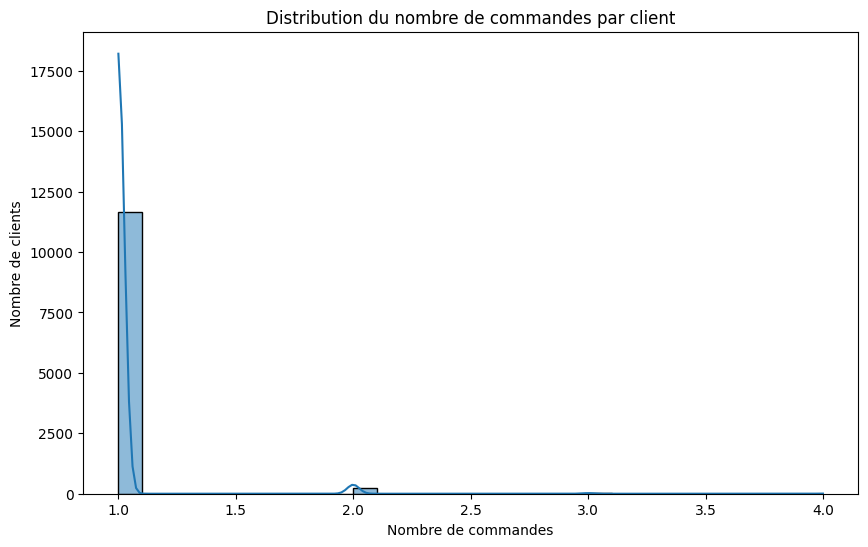

In [84]:
# Afficher la distribution de frequency
plt.figure(figsize=(10, 6))
sns.histplot(rfm_df['frequency'], bins=30, kde=True)
plt.title('Distribution du nombre de commandes par client')
plt.xlabel('Nombre de commandes')
plt.ylabel('Nombre de clients')
plt.show()

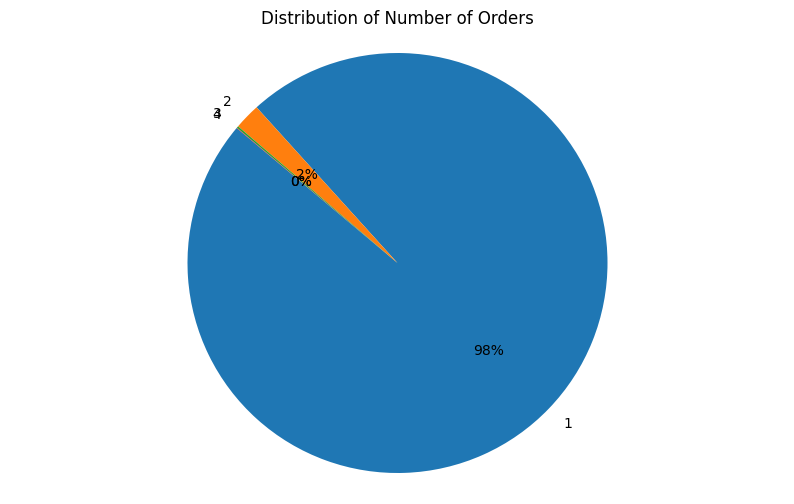

In [85]:
# Compter les occurrences de chaque nombre de commandes
order_counts = rfm_df['frequency'].value_counts()

# Créer un graphique en camembert
plt.figure(figsize=(10, 6))
plt.pie(order_counts, labels=order_counts.index, autopct='%.0f%%', startangle=140)
plt.title('Distribution of Number of Orders')
plt.axis('equal')  # Assure que le graphique est un cercle
plt.show()

### Jours depuis la dernière commande

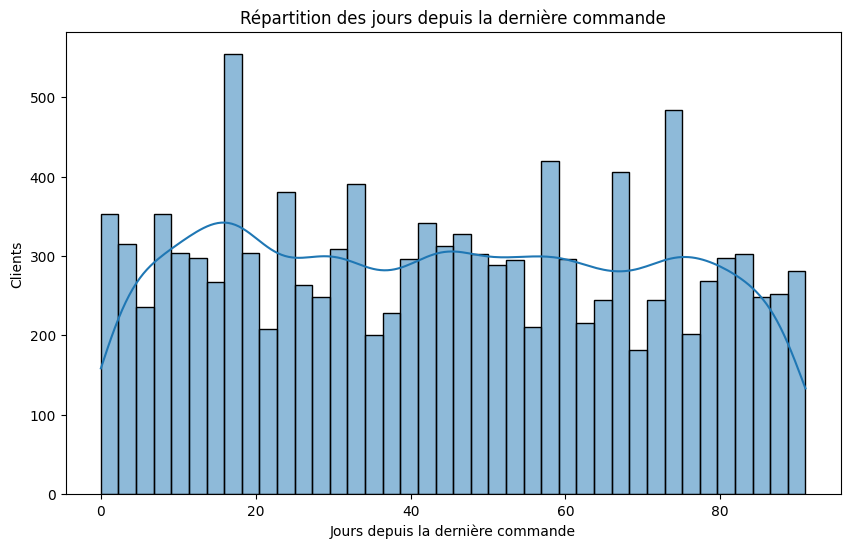

In [99]:
plt.figure(figsize=(10, 6))
sns.histplot(rfm_df['recency'], bins=40, kde=True)
plt.title('Répartition des jours depuis la dernière commande')
plt.xlabel('Jours depuis la dernière commande')
plt.ylabel('Clients')
plt.show()

### Montant total dépensé

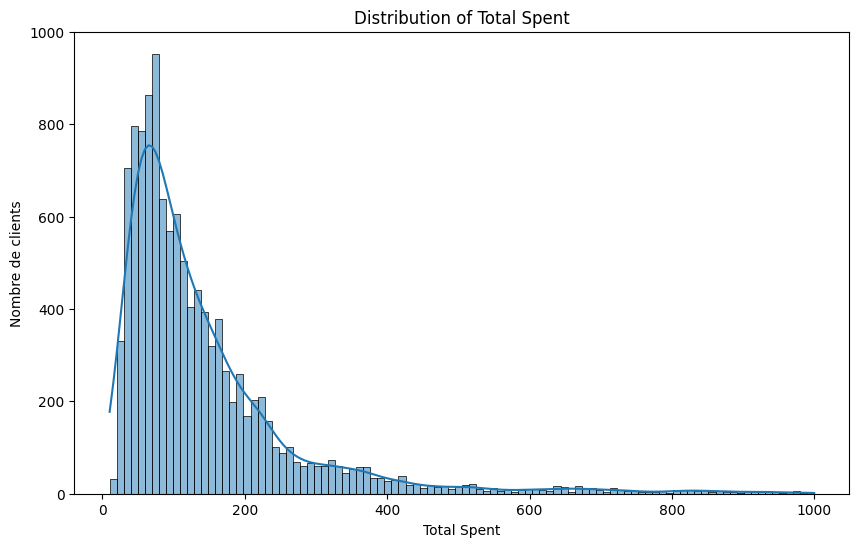

In [88]:
rfm_df_max_spent = rfm_df[rfm_df['monetary_value'] <= 1000]

plt.figure(figsize=(10, 6))
sns.histplot(rfm_df_max_spent['monetary_value'], bins=100, kde=True)
plt.title('Distribution of Total Spent')
plt.xlabel('Total Spent')
plt.ylabel('Nombre de clients')
plt.show()

### Moyenne des scores de satisfaction

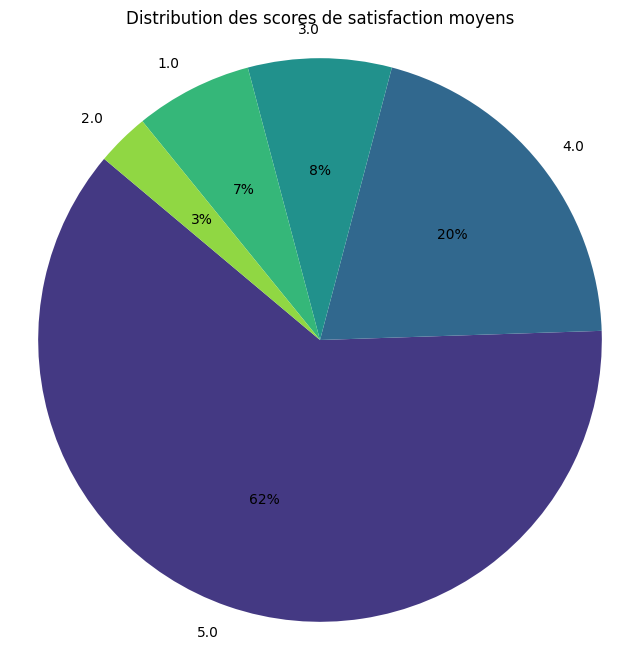

In [94]:
# Count the occurrences of each mean_review_score
review_score_counts = rfm_df['avg_review_score'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(review_score_counts, labels=review_score_counts.index, autopct='%.0f%%', startangle=140, colors=sns.color_palette('viridis', len(review_score_counts)))
plt.title('Distribution des scores de satisfaction moyens')
plt.axis('equal')
plt.show()

### Pair plot

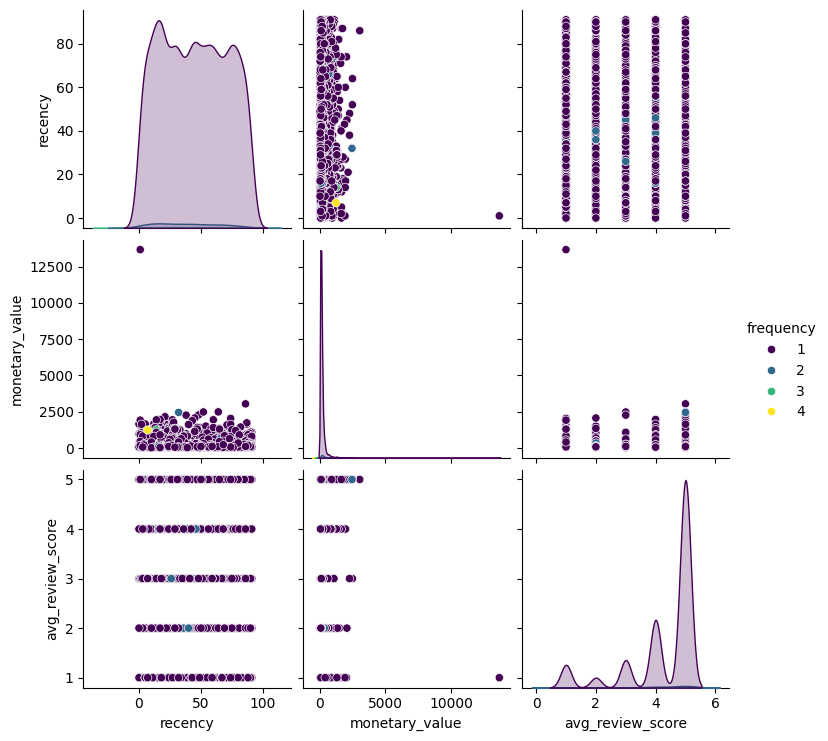

In [95]:
# Sélectionner les colonnes pertinentes pour le pairplot
columns_to_plot = ['recency', 'frequency', 'monetary_value', 'avg_review_score']

# Créer le pairplot
sns.pairplot(rfm_df[columns_to_plot], hue='frequency', palette='viridis')
plt.show()